In [1]:
import os
import sys

import numpy as np
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import colors
from hydra import initialize, compose
import pickle
from glob import glob
from pprint import pprint
from tqdm import tqdm
import random
from pyHalo.preset_models import CDM
from copy import deepcopy

# set paths to various directories based on the machine this code is being executed on
with initialize(version_base=None, config_path='../../config'):
    config = compose(config_name='config.yaml')  # overrides=['machine=uzay']

array_dir, data_dir, figure_dir, pickle_dir, repo_dir  = config.machine.array_dir, config.machine.data_dir, config.machine.figure_dir, config.machine.pickle_dir, config.machine.repo_dir

# enable use of local modules
if repo_dir not in sys.path:
    sys.path.append(repo_dir)

# set matplotlib style
plt.style.use(f'{repo_dir}/mejiro/mplstyle/science.mplstyle')

from mejiro.lenses.test import SampleStrongLens
from mejiro.lenses import lens_util
from mejiro.plots import diagnostic_plot, plot, plot_util, overplot
from mejiro.analysis import stats
from mejiro.utils import util
from mejiro.helpers import gs

In [2]:
# pickled_lens_list = os.path.join(config.machine.dir_01, '01_hlwas_sim_detectable_lens_list.pkl')
# lens_list = util.unpickle(pickled_lens_list)
# lens = random.choice(lens_list)

In [3]:
num_lenses = 100
print(f'Collecting {num_lenses} lenses...')
pickled_lens_list = os.path.join(config.machine.dir_01, '01_hlwas_sim_detectable_lens_list.pkl')
lens_list = util.unpickle(pickled_lens_list)[:num_lenses]
print(f'Collected {len(lens_list)} lens(es).')

Collected 100 lens(es).


In [4]:
subhalo_params = {
    'r_tidal': 0.5,
    'sigma_sub': 0.055,
    'subhalo_cone': 5,
    'los_normalization': 0
}
imaging_params = {
    'bands': ['F106'],
    'oversample': 5,
    'num_pix': 45,
    'side': 4.95
}

r_tidal = subhalo_params['r_tidal']
sigma_sub = subhalo_params['sigma_sub']
subhalo_cone = subhalo_params['subhalo_cone']
los_normalization = subhalo_params['los_normalization']
bands = imaging_params['bands']
oversample = imaging_params['oversample']
num_pix = imaging_params['num_pix']
side = imaging_params['side']

In [5]:
# get sample lens
lens = np.random.choice(lens_list)
lens._set_classes()

In [6]:
without_subhalo = lens.get_array(45, 4.95, 'F106')

In [7]:
z_lens = round(lens.z_lens, 2)
z_source = round(lens.z_source, 2)
log_m_host = np.log10(lens.main_halo_mass)

cut_8_good = False
i = 0

while not cut_8_good:
    cut_8 = CDM(z_lens,
                z_source,
                sigma_sub=sigma_sub,
                log_mlow=8.,
                log_mhigh=10.,
                log_m_host=log_m_host,
                r_tidal=r_tidal,
                cone_opening_angle_arcsec=subhalo_cone,
                LOS_normalization=los_normalization)
    cut_8_good, halo = lens_util.check_halo_image_alignment(lens, cut_8, halo_mass=1e6, halo_sort_massive_first=False, return_halo=True)
    i += 1
print(f'Generated cut_8 population after {i} iterations.')

Generated cut_8 population after 310 iterations.


In [8]:
pprint(halo.mass * 1e-8)

2.622336392314406


In [9]:
pprint(halo.params_physical)

{'r200': 4.650340172671358,
 'r_trunc_kpc': 0.14019570020019909,
 'rhos': 16988106.687313892,
 'rs': 1.1444231711287913}


In [10]:
pprint(halo.lenstronomy_params)

([{'Rs': 1.3295670308,
   'alpha_Rs': 0.0008009087,
   'center_x': -0.2981,
   'center_y': 0.0317,
   'r_trunc': 0.058430480638796654}],
 None)


In [11]:
halo.lenstronomy_ID

['TNFW']

In [12]:
lens.kwargs_lens.append(halo.lenstronomy_params[0][0])
lens.lens_redshift_list += halo.z
lens.lens_model_list += halo.lenstronomy_ID

from lenstronomy.LensModel.lens_model import LensModel
lens.lens_model_class = LensModel(lens.lens_model_list)

In [13]:
pprint(lens.kwargs_lens)

[{'center_x': 0.05610736457883662,
  'center_y': 0.020053973955505938,
  'e1': 0.31895676995452815,
  'e2': -0.47957972106252555,
  'gamma': 2,
  'theta_E': 0.7535174375794983},
 {'dec_0': 0,
  'gamma1': 0.003750641129686577,
  'gamma2': -0.004889091148466559,
  'ra_0': 0},
 {'dec_0': 0, 'kappa': -0.025400566253103354, 'ra_0': 0},
 {'Rs': 1.3295670308,
  'alpha_Rs': 0.0008009087,
  'center_x': -0.2981,
  'center_y': 0.0317,
  'r_trunc': 0.058430480638796654}]


In [14]:
with_subhalo = lens.get_array(45, 4.95, 'F106')

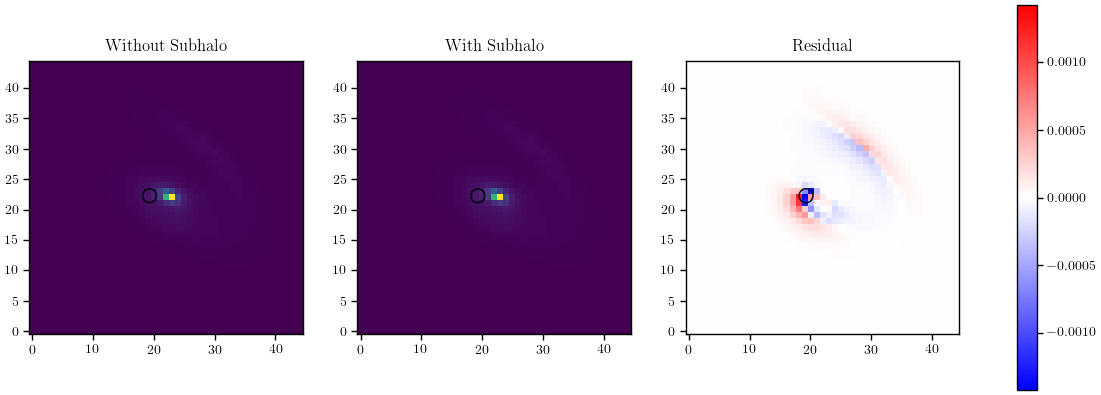

In [15]:
residual = with_subhalo - without_subhalo

f, ax = plt.subplots(1, 3, figsize=(15, 5))
ax[0].imshow(without_subhalo)
ax[0].set_title('Without Subhalo')
ax[1].imshow(with_subhalo)
ax[1].set_title('With Subhalo')
axis = ax[2].imshow(residual, cmap='bwr', vmin=-np.max(np.abs(residual)), vmax=np.max(np.abs(residual)))
ax[2].set_title('Residual')

cbar = f.colorbar(axis, ax=ax)

coords = lens_util.get_coords(45, delta_pix=0.11)
for a in ax:
    a.scatter(*coords.map_coord2pix(halo.x, halo.y), s=100, facecolors='none', edgecolors='black')

plt.show()